In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
import seaborn as sns

In [2]:
# original data obtained from https://archive.ics.uci.edu/ml/datasets/Online%20Retail
df = pd.read_csv('../data/Online_Retail.csv')

### RTFM 

Calculate:
    - Recency: the number of month since the last purchase
    - Frequency: number of purchases
    - MonetaryValue: total spendature
    - Tenure: the number of month since the first purchase

In [10]:
# Frame the data to be within a complete year
online = df[(df.InvoiceDate>='2010-12-10') & (df.InvoiceDate<='2011-12-09')].copy()

# Filter out records with null CustomerIDs
online = online[~online.CustomerID.isnull()].copy()

# Assuming the current date is one day after the max Invoice Date
today = online.InvoiceDate.max() + timedelta(days=1)

In [27]:
# Group the data by CustomerID
grouping = online.groupby('CustomerID')

# Find the first & last purchase date of each customer
online['FirstPurchaseDate'] = grouping['InvoiceDate'].transform('min')
online['LastPurchaseDate'] = grouping['InvoiceDate'].transform('max')

In [164]:
# Calculate Recency and Tenure by count the number of month between first/last purchase date and today
online['Recency'] = (today.year - online['LastPurchaseDate'].dt.year) * 365 + (today.month - online['LastPurchaseDate'].dt.month) * 30 + (today.day - online['LastPurchaseDate'].dt.day) + 1
online['Tenure'] = (today.year - online['FirstPurchaseDate'].dt.year) * 365 + (today.month - online['FirstPurchaseDate'].dt.month) * 30 + + (today.day - online['FirstPurchaseDate'].dt.day) +  1

# Count the number of invoices per customer
online['Frequency'] = grouping['InvoiceNo'].transform('count')

# Calculate TotalSum for each row, and then sum the TotalSum column to get the MonetaryValue
online['TotalSum'] = online['UnitPrice'] * online['Quantity']
online['MonetaryValue'] = grouping['TotalSum'].transform('sum')


# Clean up the data for further preprocessing
online_rtfm = online[['CustomerID', 'Recency', 'Tenure', 'Frequency', 'MonetaryValue']].drop_duplicates()

# Remove customers with negative and 0 total spending
online_rtfm = online_rtfm[online_rtfm.MonetaryValue>0].copy()


### Standardize the RTFM data for KMeans

The prerequisite of KMeans is to have:
    - unskewed data
    - data with the same mean and standard deviation

#### Visualize the skewness of the RTFM data

original data (left), log transformation (right)

/Users/cheng/.envs/edge/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


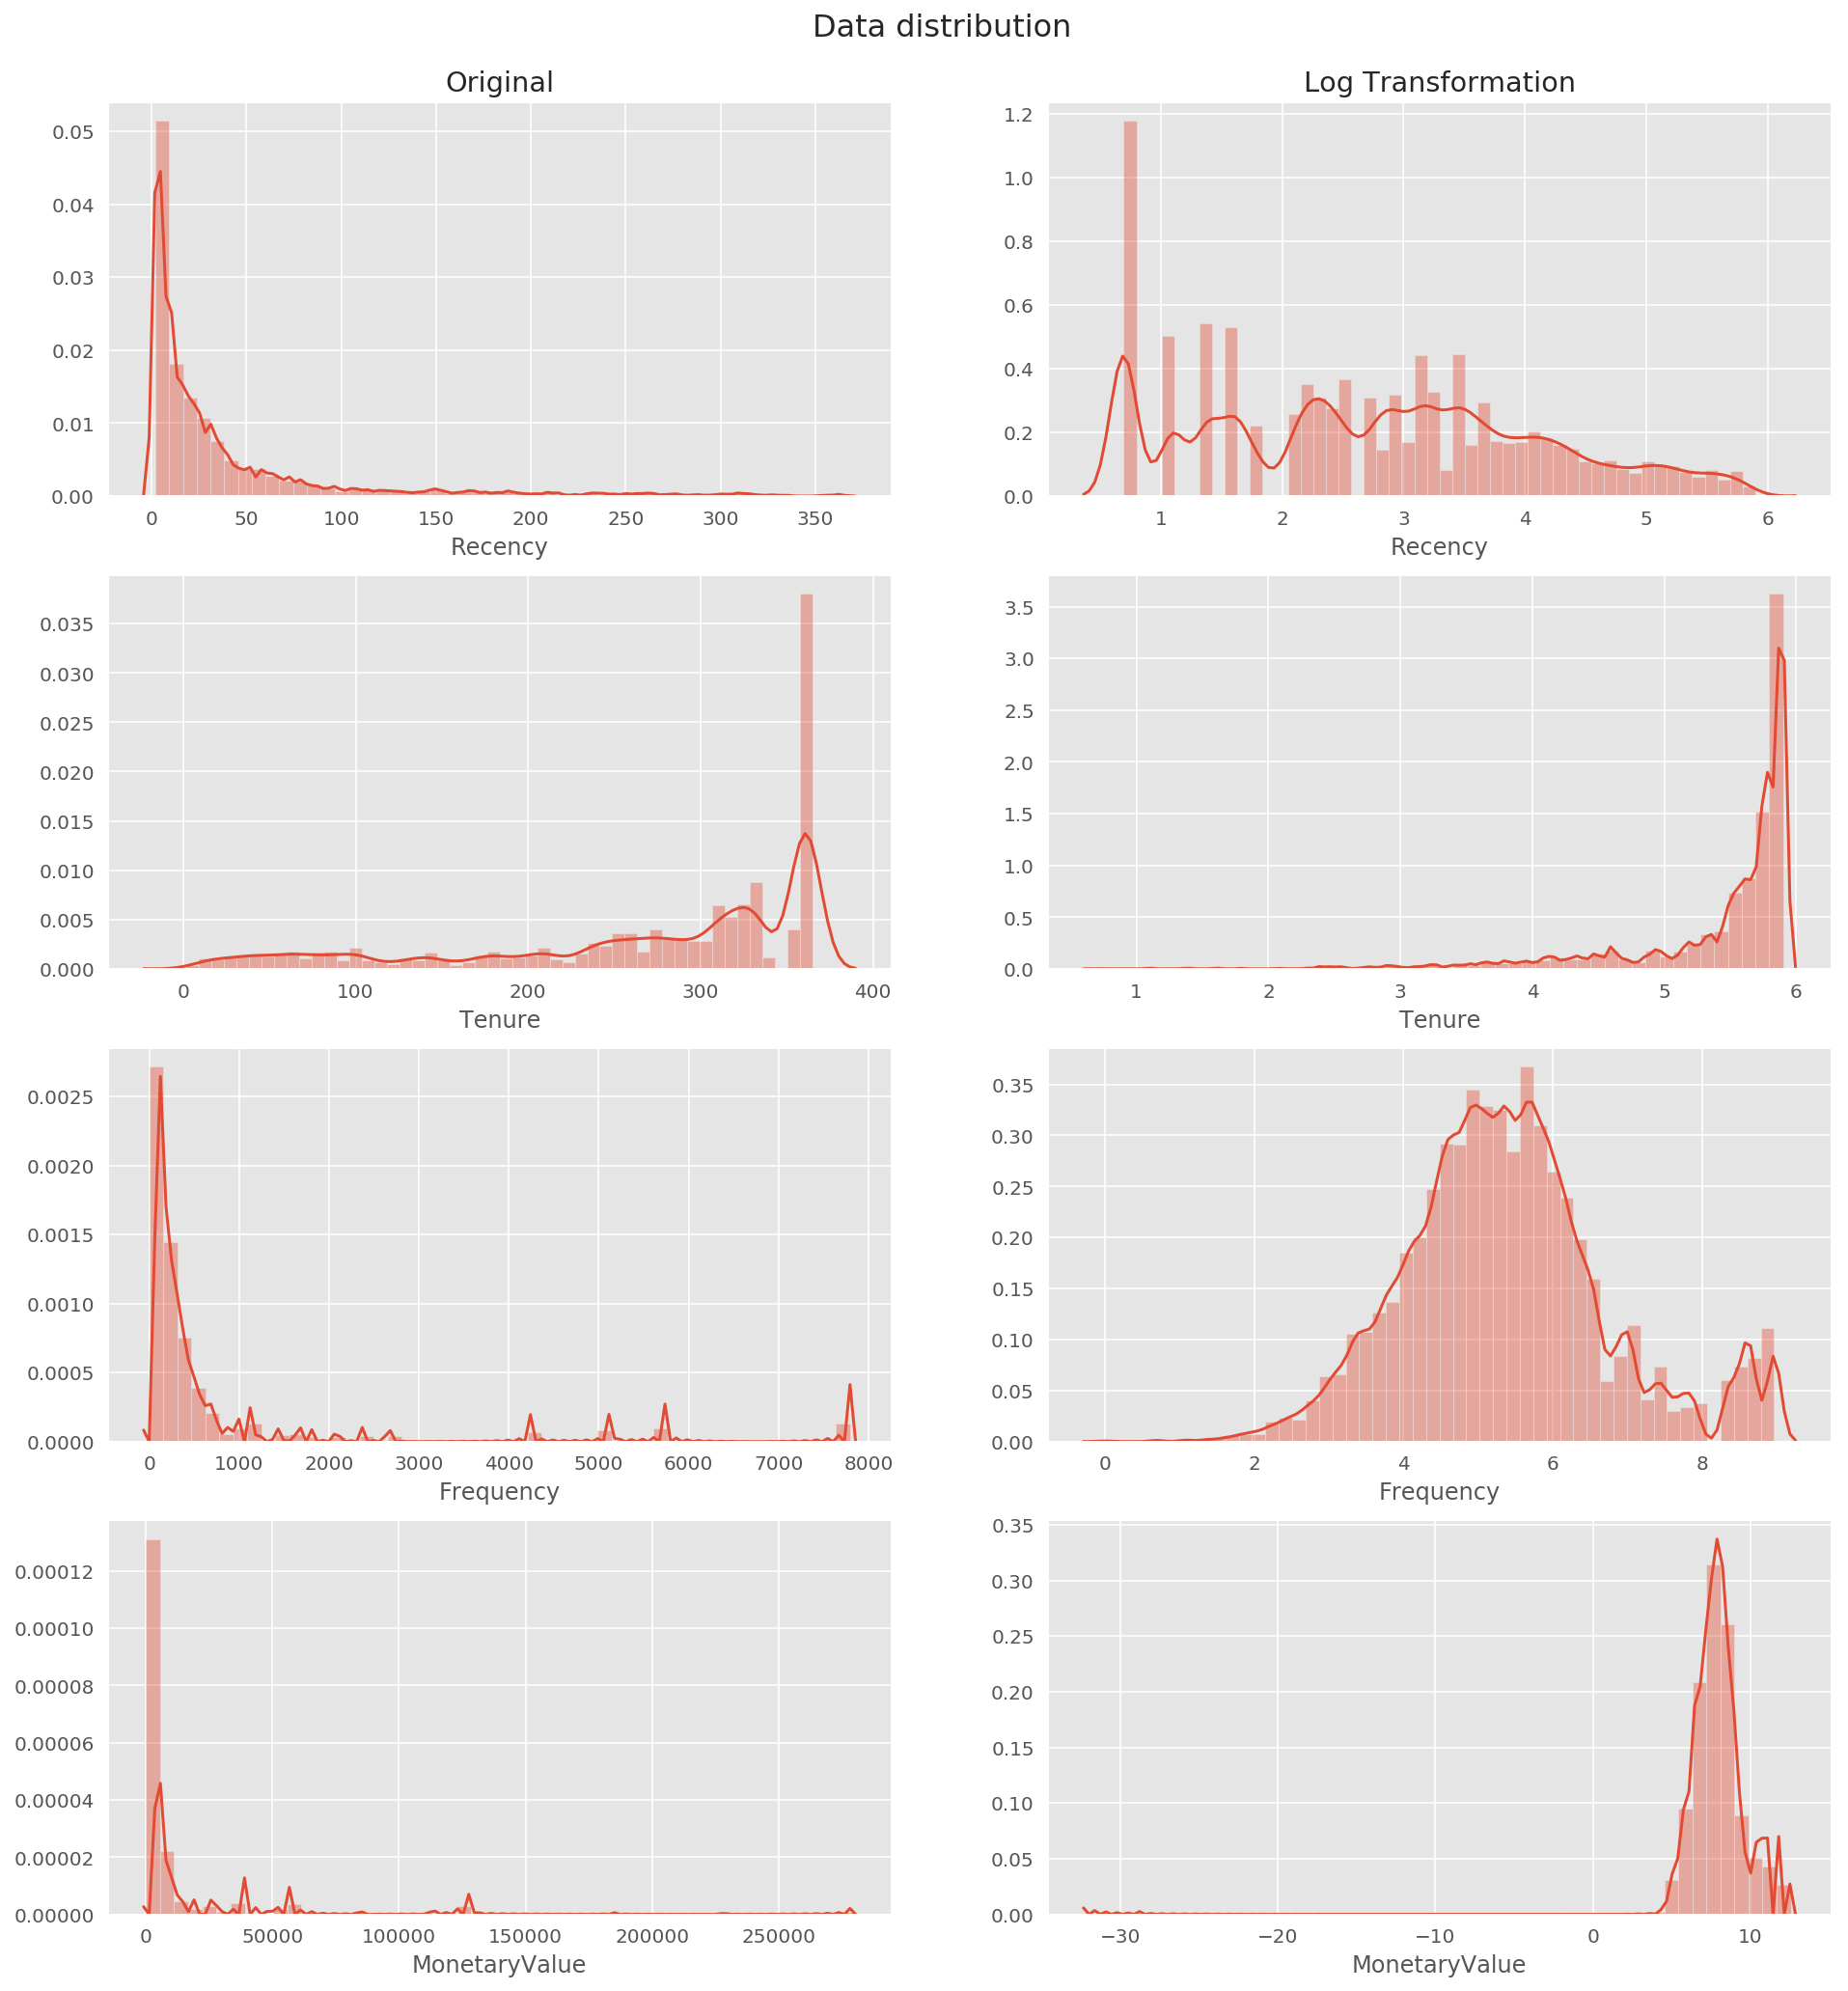

In [152]:
f, axarr = plt.subplots(4,2,figsize=(16,16))
f.subplots_adjust(top=0.94) # shrink the gap between the title and the first row
f.suptitle('Data distribution', fontsize='16')

axarr[0,0].set_title('Original')
axarr[0,1].set_title('Log Transformation')

sns.distplot(online_rtfm['Recency'], ax=axarr[0,0]); 
sns.distplot(np.log(online_rtfm['Recency']), ax=axarr[0,1]); 

sns.distplot(online_rtfm['Tenure'], ax=axarr[1,0]); 
sns.distplot(np.log(online_rtfm['Tenure']), ax=axarr[1,1]); 

sns.distplot(online_rtfm['Frequency'], ax=axarr[2,0]);
sns.distplot(np.log(online_rtfm['Frequency']), ax=axarr[2,1]);

sns.distplot(online_rtfm['MonetaryValue'], ax=axarr[3,0]);
sns.distplot(np.log(online_rtfm['MonetaryValue']), ax=axarr[3,1]);

In [166]:
online_rtfm_log = np.log(online_rtfm[['Recency', 'Tenure', 'Frequency', 'MonetaryValue']])

#### Standardizaiton

In [178]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
normalized = scaler.fit_transform(online_rtfm_log)

online_rtfm_log_norm = pd.DataFrame(normalized, index=online_rtfm_log.index, columns=online_rtfm_log.columns)
online_rtfm_log_norm.describe()

,Recency,Tenure,Frequency,MonetaryValue
count,4247.00000,4247.00000,4247.00000,4247.00000
mean,-0.00000,0.00000,0.00000,0.00000
std,1.00012,1.00012,1.00012,1.00012
min,-2.24947,-4.91946,-2.84125,-21.58071
25%,-0.66400,-0.49296,-0.62321,-0.45407
50%,0.07347,0.42977,0.02699,-0.01748
75%,0.83165,0.72696,0.69270,0.48598
max,1.60797,0.91355,4.03529,3.37623


### Deciding on the initial KMeans core counts

In [179]:
from sklearn.cluster import KMeans

sse = {}
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=1)
    sse[i] =  kmeans.fit(online_rtfm_log_norm).inertia_

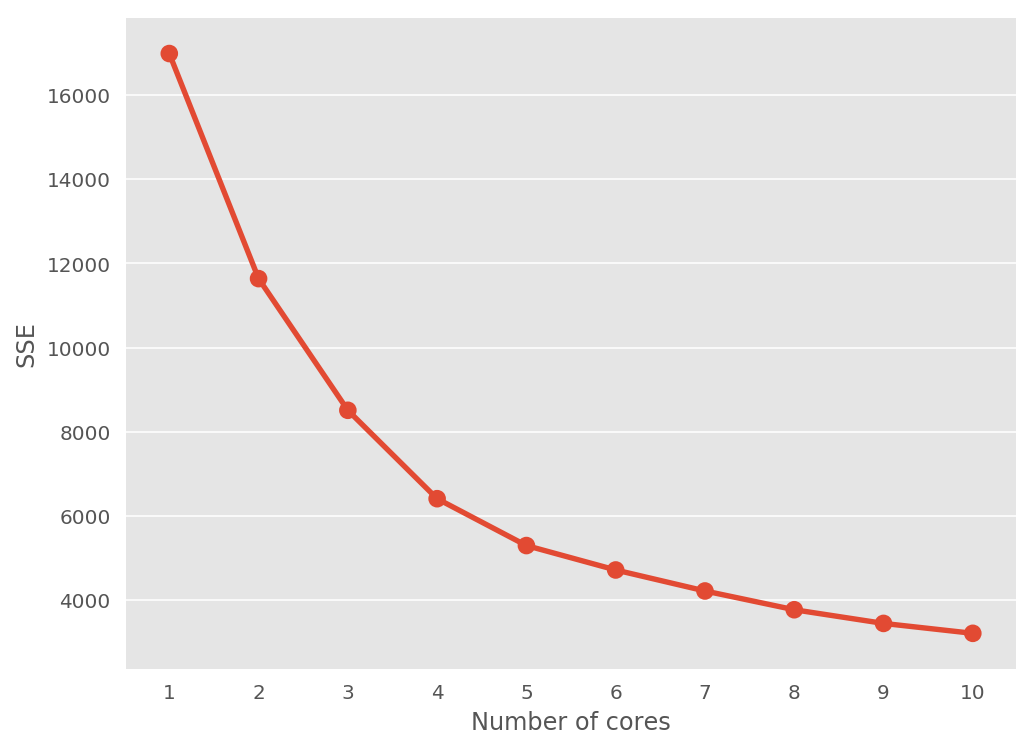

In [182]:
plt.figure(figsize=(8,6))
plt.xlabel('Number of cores')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))

From the plot above, we can see that the 'elbow point' is at core = 4

### Perform KMeans Clustering

In [183]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
kmeans.fit(online_rtfm_log_norm)
cluster_labels = kmeans.labels_

In [185]:
online_rtfm['Cluster'] = cluster_labels
online_rtfm.groupby(['Cluster']).agg({
    'Recency': 'mean',
    'Tenure': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
})

Tenure   Recency MonetaryValue       Frequency
             mean      mean          mean count      mean
Cluster                                                  
0       240.63754 170.10626     547.35391  1694  28.30697
1       274.90960  26.01632    4134.25994  1593 194.13622
2        50.80733  33.76859     502.90021   955  35.21571
3        77.00000  69.00000       0.00000     5  56.00000

There are four clusters of customers and are mainly differentiated by their tenure, total spending and purchase frequency.
    
Both Cluster 0 & 1 are seasoned customers who have made their first purchase eight months ago. The main difference between 0 & 1 is their purchase frequency and total spending. On average, Cluster 1 customers make purchases seven times more frequent than Cluster 0 customers. Also, they spend seven times more in total.

Cluster 2 & 3  are relatively new customers who have made their first purchases three months ago. They mainly differ in the total amount of spending. There are only five customers within Cluster 3. They have made 56 transactions but the 0 total spending. The data looks suspicious and requires further investigation on these five customers.

#### Suspicious segment

In [188]:
online[online.CustomerID.isin(online_rtfm[online_rtfm.Cluster==3].CustomerID)].describe()

,Quantity,UnitPrice,CustomerID,Recency,Tenure,Frequency,TotalSum,MonetaryValue
count,280.00000,280.00000,280.00000,280.00000,280.00000,280.00000,280.00000,280.00000
mean,0.00000,2.19193,13160.23571,58.17857,62.17143,151.31429,0.00000,0.00000
std,17.61943,2.26971,1527.54656,37.47157,38.58797,81.72785,21.44787,0.00000
min,-96.00000,0.42000,12558.00000,2.00000,8.00000,14.00000,-104.40000,0.00000
25%,-12.00000,0.85000,12607.00000,58.00000,60.00000,22.00000,-15.00000,0.00000
50%,0.00000,1.45000,12607.00000,58.00000,60.00000,202.00000,0.00000,0.00000
75%,12.00000,2.90500,12607.00000,58.00000,60.00000,202.00000,15.00000,0.00000
max,96.00000,16.95000,18274.00000,201.00000,215.00000,202.00000,104.40000,0.00000


As we can see from the Quantity column, some values are marked as negative. It is unknown why these values are negative as explanations are not provided.

We may:
- consider to filter out data with negative quantity to start with (if it doesn't affect the main objective) or
- try 3 clusters instead of 4

### Relative Importances of Segment Attribute

To visualize the main difference between each cluster and the entire dataset, each cluster's average is divided by the population's average - 1. The further a ratio is from 0, the more different it is from the population mean.

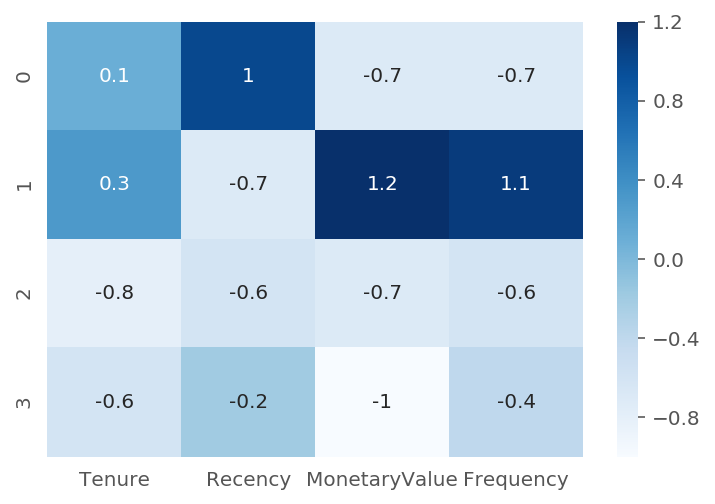

In [208]:
# Calculate averages for RTFM
online_clusters = online_rtfm.groupby(['Cluster']).agg({
    'Recency': 'mean',
    'Tenure': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean'
}).reset_index()

# Calculate population average
population_mean = online_rtfm[['Tenure', 'Recency', 'MonetaryValue', 'Frequency']].mean()

# RTFM / Populatoin_mean - 1
diff = online_clusters[['Tenure', 'Recency', 'MonetaryValue', 'Frequency']]/population_mean - 1

# Show heatmap
sns.heatmap(data=diff.round(1), annot=True, cmap='Blues')

Cluster 0: Recency is quite different from population mean  
Cluster 1: MonetaryValue & Frequency  
Cluster 2: Nothing stands out  
Cluster 3: Monetary value  

### Using Snake Plot to Visualize the Clusters

In [210]:
# Create a new column named 'Attribute' and fold 'Recency, Tenure, Frequency & MonetaryValue' into 'Attribute'
online_rtfm_melt = pd.melt(online_rtfm,
        id_vars = ['CustomerID', 'Cluster'],
        value_vars = ['Recency', 'Tenure', 'Frequency', 'MonetaryValue'],
        var_name = 'Attribute',
        value_name = 'value'
       )

In [212]:
online_rtfm_melt.head()

,CustomerID,Cluster,Attribute,value
0,15805.00000,1,Recency,24.00000
1,12471.00000,1,Recency,3.00000
2,17675.00000,1,Recency,2.00000
3,17696.00000,1,Recency,39.00000
4,13418.00000,1,Recency,12.00000


/Users/cheng/.envs/edge/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


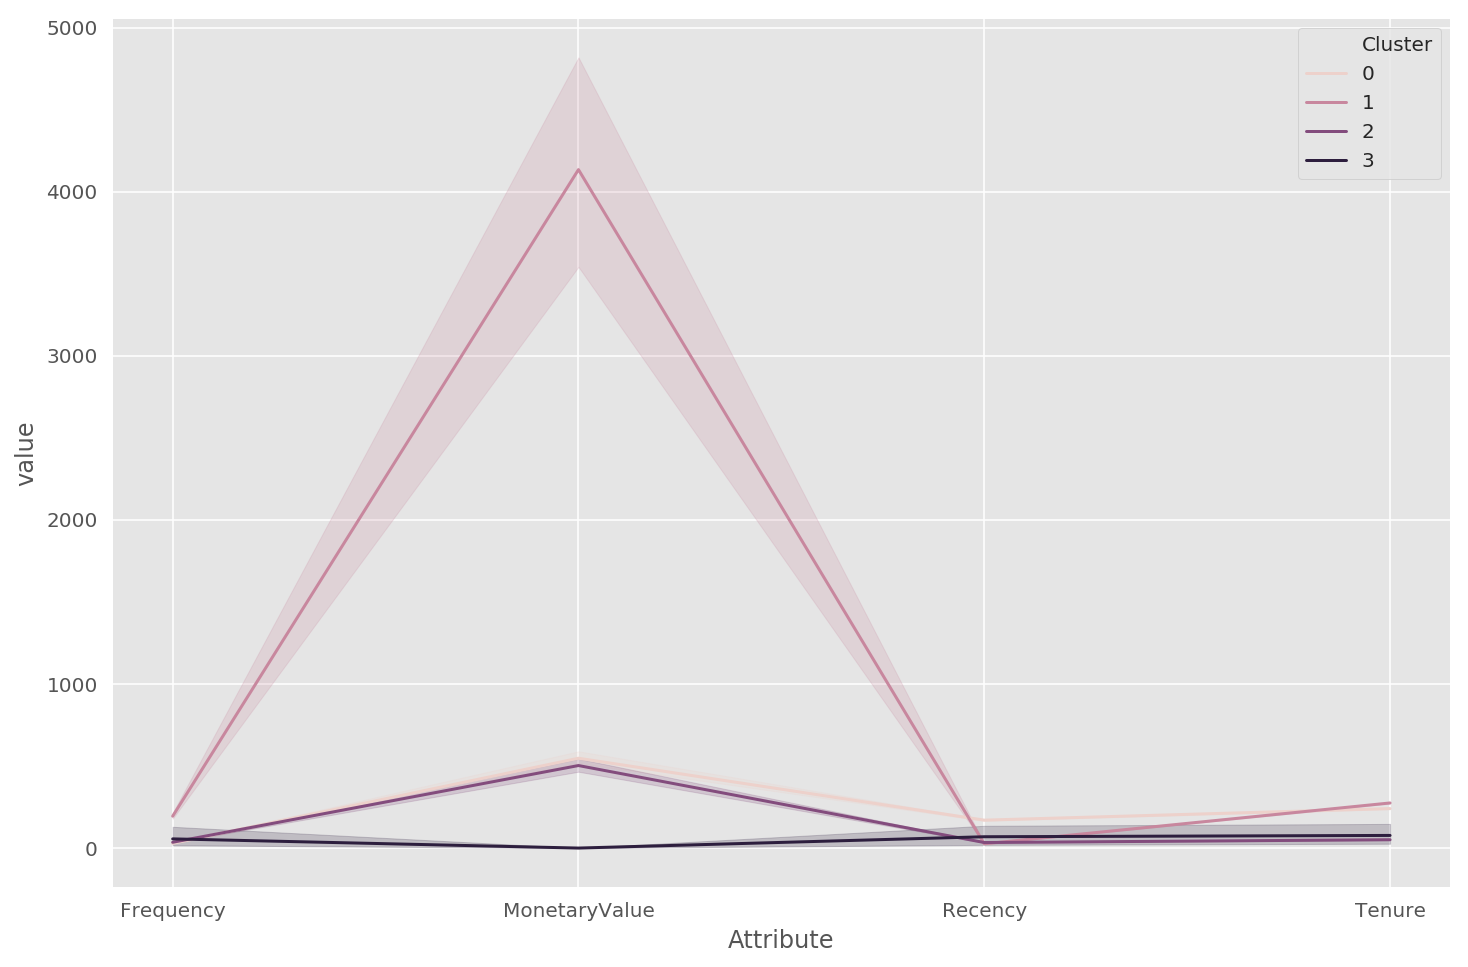

In [217]:
plt.figure(figsize=(12,8))
sns.lineplot(data = online_rtfm_melt,
             x = 'Attribute',
             y = 'value',
             hue = 'Cluster'
            )

The snake plot above shows the difference among the clusters visually. The more prominent feature is the huge spike of Cluster 1's MonetaryValue attribue.

Another main difference is Cluster 0's Recency. This is hard to observe visually due to the fact that MonetaryValue's max value is over 4000, but the max value of Recency is 365 as shown below.

In [218]:
online_rtfm.groupby('Cluster').Recency.describe()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,1694.00000,170.10626,90.25293,9.00000,92.00000,163.00000,244.00000,365.00000
1,1593.00000,26.01632,27.71464,2.00000,8.00000,18.00000,34.00000,263.00000
2,955.00000,33.76859,22.42266,2.00000,15.00000,30.00000,52.00000,85.00000
3,5.00000,69.00000,78.49204,2.00000,18.00000,58.00000,66.00000,201.00000
